# Histogram-based segmentation

In this notebook, we take an image, denoise it, process the histogram to find valleys and create segments based on these findings. This is called histogram-based sgmentation.

## 1) Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from skimage import io, img_as_float, img_as_ubyte
from skimage.restoration import denoise_nl_means, estimate_sigma
from skimage.metrics import peak_signal_noise_ratio
from skimage.util import random_noise

## 2) Read Image

Convert the image to floating point values:  most of the filters are expecting pixels values as float.

In [9]:
img = img_as_float(io.imread('images/embryos_noisy.tif'))

## 3) Filter the image

Remove noise in the image using Non Local Means Denoising

Image info:  (554, 948)
Length of the estimate_sigma list 948


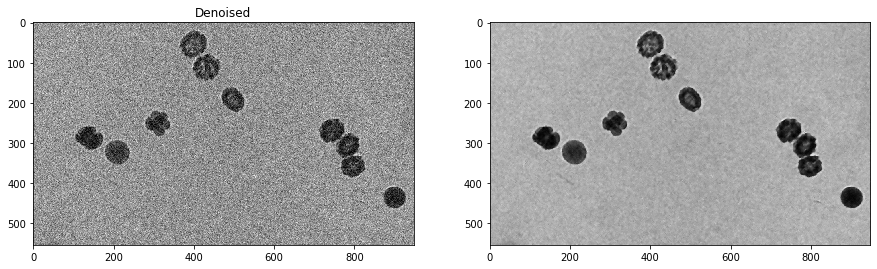

In [3]:
#Put the parameters of the filter in a dictionary
patch_kw = dict(patch_size=5,      # 5x5 patches
                patch_distance=3,  # 13x13 search area
                multichannel=True)


#Get info on the image
print('Image info: ', img.shape)
print('Length of the estimate_sigma list', len(estimate_sigma(img, multichannel=True)))


#Estimate the sigma parameter by averaging the estimations over each column
sigma_estimation = np.mean(estimate_sigma(img, multichannel=True))

#Filter the image
denoise = denoise_nl_means(img, h=1.15 * sigma_estimation, fast_mode=True,**patch_kw)

#Show the results
fig, ax = plt.subplots(nrows=1,ncols=2, figsize= (15,15));
ax[0].imshow(img, cmap='gray');
ax[0].set_title('Original');
ax[1].imshow(denoise, cmap='gray');
ax[0].set_title('Denoised');

## 4) Show the histogram

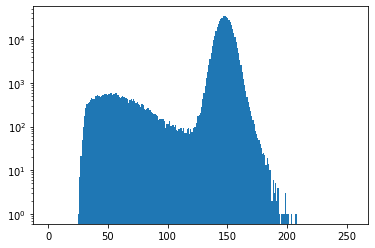

In [4]:
denoise_ubyte = img_as_ubyte(denoise)
denoise_ubyte_flat = denoise_ubyte.flat # flat flattens the pixel values to one single column
fig2, ax2 = plt.subplots(nrows=1,ncols=1)
ax2.hist(denoise_ubyte_flat, bins=255, range=(0, 255), log=True); # semi-colon to hide the histogram values

## 5) Find valleys (optional)

We can either hard code the intensity we think are good for segmentation, or try to find them automatically. Using *signal.argrelextrema()*, we can find the values of the valleys. We can fine-tune the number of valleys detected by changing the order value, which is the number of values taken into account before and after a valley.

In [5]:
from scipy import signal

n = ax2.hist(denoise_ubyte.flat, bins=255, range=(0, 255), log=True); #get the values of the bins as an array
valley_indexes = signal.argrelextrema(n[0], np.less, order=7) # np.less to get the valleys, order to adjust the search
print('List of valley indexes: ',valley_indexes[0])


List of valley indexes:  [ 98 118 194]


## 6) Define the segments

Based on the previous step, or empirically, we can define the segments using boolean operations

In [6]:
#create the segments (see sample function below for better automation)
thresholds = valley_indexes[0]

segm1 = (denoise_ubyte <= thresholds[0])
segm2 = (denoise_ubyte > thresholds[0]+1) & (denoise_ubyte <= thresholds[1] )
segm3 = (denoise_ubyte > thresholds[1]+1) & (denoise_ubyte <= thresholds[2] )
segm4 = (denoise_ubyte > thresholds[2]+1) & (denoise_ubyte <= 255 )

#create an empty RGB image of the same size as the original
all_segments = np.zeros((denoise_ubyte.shape[0], denoise_ubyte.shape[1], 3))

#Assign colors to the segments
all_segments[segm1] = (1,0,0)
all_segments[segm2] = (0,1,0)
all_segments[segm3] = (0,0,1)
all_segments[segm4] = (1,1,0)

## 7) Show the results

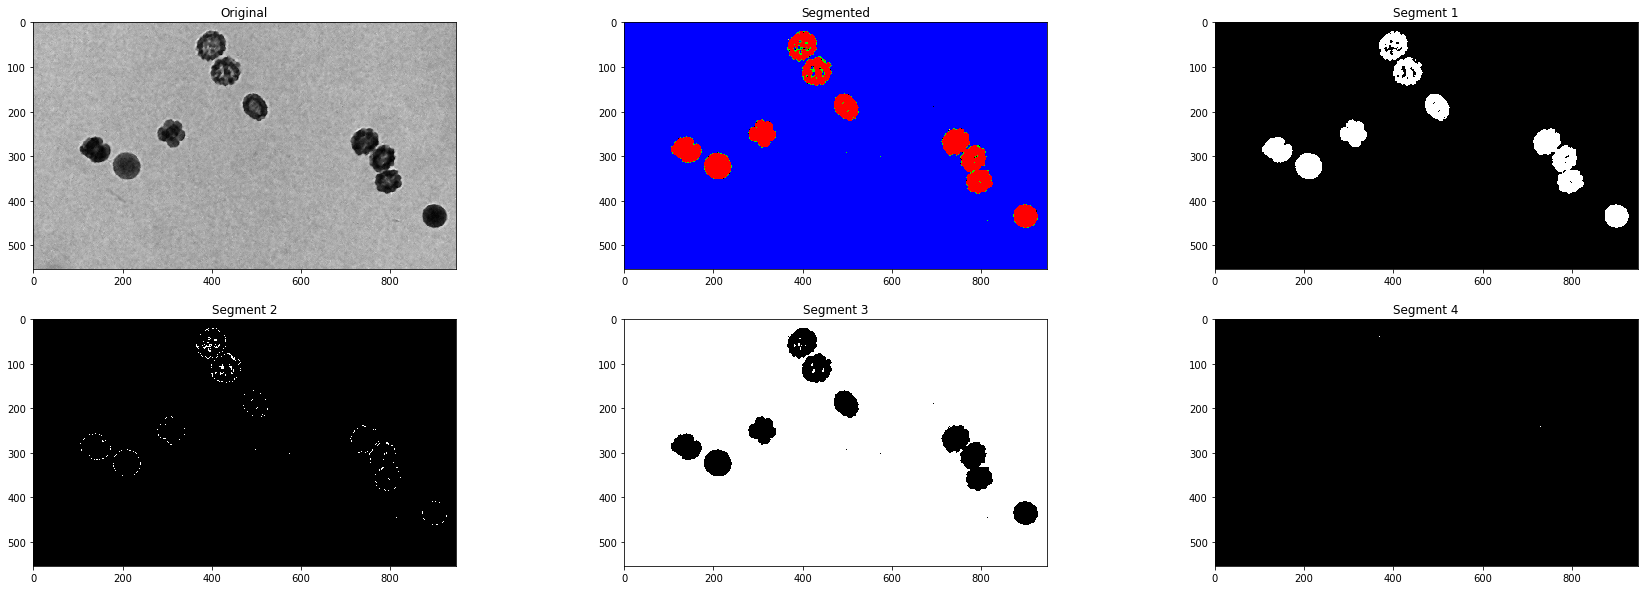

In [7]:
#Show the results
fig = plt.figure(figsize=(30,10))
fig.add_subplot(2,3,1)
plt.imshow(denoise, cmap='gray')
plt.title('Original')

fig.add_subplot(2,3,2)
plt.imshow(all_segments)
plt.title('Segmented')

fig.add_subplot(2,3,3)
plt.imshow(segm1, cmap='gray')
plt.title('Segment 1')
fig.add_subplot(2,3,4)
plt.imshow(segm2, cmap='gray')
plt.title('Segment 2')
fig.add_subplot(2,3,5)
plt.imshow(segm3, cmap='gray')
plt.title('Segment 3')
fig.add_subplot(2,3,6)
plt.imshow(segm4, cmap='gray')
plt.title('Segment 4');

## Going further

In [8]:
#Sample function to automate the segmentation 

#def segmentation(image, tresholds_table):
#     num_tresh =  len(thresholds_table)
#     segments = []
#     max_ = 255
    
#     for index in num_tresh:
#         if index == 0:
#             segments[index] = (image <= thresholds_table[index])
#         elif index < num_tresh:
#             segments[index] = (image > thresholds_table[index]+1) & (image <= thresholds_table[index+1] )
#         else:
#             segments[index] = (image > thresholds_table[index]+1) & (image <= max_)
    
#     return segments